In [1]:

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import pickle
%matplotlib inline
import multiprocessing as mp
from scipy.sparse import csr_matrix

import requests #lets us leverage HTML code
from bs4 import BeautifulSoup #Web Scraper
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
import unicodedata
from keras.preprocessing.text import Tokenizer


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import metrics
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, RNN, SimpleRNN
from keras.layers import ConvRNN2D, SpatialDropout1D, Reshape, MaxPool2D, Concatenate, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D, Conv2D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.python.client import device_lib
from keras import Sequential
from keras.utils import plot_model

import os
os.environ["PATH"] += os.pathsep + '/home/nbatanay/.conda/envs/nlp_env/bin/'
from PIL import Image

#GPU configs
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

gpu_options = K.tf.GPUOptions(per_process_gpu_memory_fraction = 1)
config = K.tf.ConfigProto(gpu_options = gpu_options, allow_soft_placement = True)
K.set_session(K.tf.Session(config = config))

[dev.name for dev in device_lib.list_local_devices()]

Using TensorFlow backend.


['/device:CPU:0', '/device:GPU:0']

In [2]:
base_path = "/home/nbatanay/.kaggle/quora-insincere-questions-classification/"
train_df = pd.read_csv(base_path+"train.csv")
test_df = pd.read_csv(base_path+"test.csv")
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (56370, 2)


In [3]:
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
%%time
## split to train and val
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2018)

## some config values 
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

## fill up the missing values
train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values
test_X = test_df["question_text"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## Get the target values
train_y = train_df['target'].values
val_y = val_df['target'].values

CPU times: user 50 s, sys: 636 ms, total: 50.7 s
Wall time: 47.4 s


In [5]:
#let's store the resulting tokens
train_df["tokens"] = tokenizer.sequences_to_texts(train_X)
train_df["tokens"] = train_df["tokens"].apply(lambda x: x.split(" "))

val_df["tokens"] = tokenizer.sequences_to_texts(val_X)
val_df["tokens"] = val_df["tokens"].apply(lambda x: x.split(" "))

test_df["tokens"] = tokenizer.sequences_to_texts(test_X)
test_df["tokens"] = test_df["tokens"].apply(lambda x: x.split(" "))

In [6]:
train_df.head()

,qid,question_text,target,tokens
651064,7f8590ef60e30b4344fd,What have been the best exhibits at the Museo ...,0,"[what, have, been, the, best, exhibits, at, th..."
1294259,fda9538a2e0a5b2dfc3c,How can I rotate batch image files?,0,"[how, can, i, rotate, batch, image, files]"
1205706,ec528b4e3abc3347cd21,Which is the best cable operator in Thane west...,0,"[which, is, the, best, cable, operator, in, th..."
460090,5a1a41ea2086f2264eab,"How do I expand, factor and simplify in algebra?",0,"[how, do, i, expand, factor, and, simplify, in..."
1277213,fa4f394af94b2b094e15,Do you judge people often?,0,"[do, you, judge, people, often]"


### Without Embeddings

#### 1. Fast GRU neural net architecture

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          330240    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                4112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total para

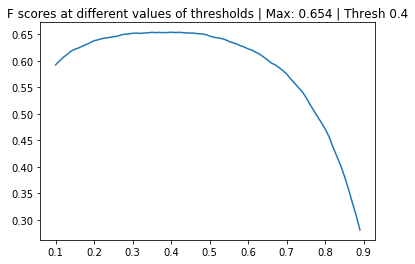

In [7]:
%%time
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())
## Train the model 
model.fit(train_X, train_y, batch_size=512, epochs=3, validation_data=(val_X, val_y))

#plot the best threshold and metric
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))

#### 2. LSTM architecture

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 256)          439296    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                4112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total para

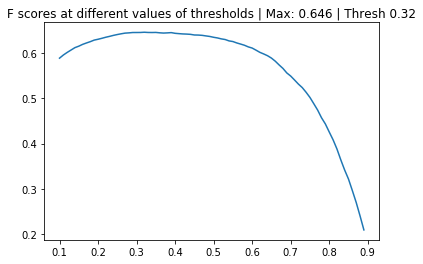

In [8]:
%%time
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())
## Train the model 
model.fit(train_X, train_y, batch_size=512, epochs=3, validation_data=(val_X, val_y))

#plot the best threshold and metric
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))

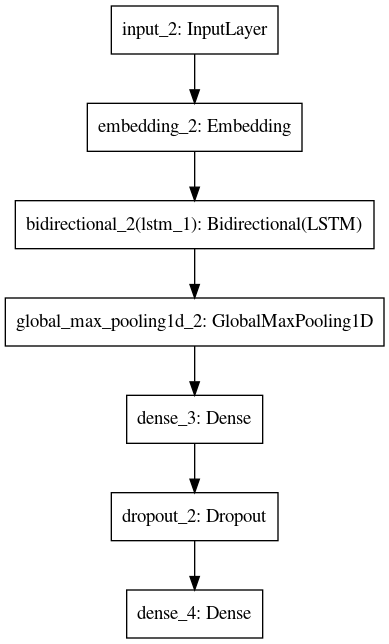

In [9]:
plot_model(model, to_file="model.png")
image = Image.open("model.png")
image

#### 3.  Recurrent Neural Net Architecture

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 256)          109824    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                4112      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total para

/home/nbatanay/.conda/envs/nlp_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nbatanay/.conda/envs/nlp_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nbatanay/.conda/envs/nlp_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nbatanay/.conda/envs/nlp_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nbatan

CPU times: user 26min 5s, sys: 2min 57s, total: 29min 2s
Wall time: 13min 9s


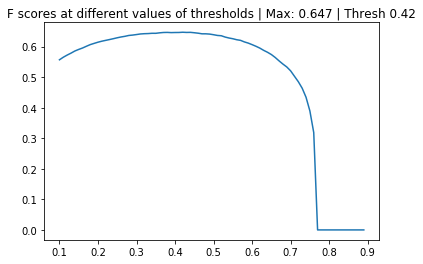

In [10]:
%%time
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(SimpleRNN(128, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())
## Train the model 
model.fit(train_X, train_y, batch_size=512, epochs=3, validation_data=(val_X, val_y))

#plot the best threshold and metric
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))

#### 4. CNN

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 100, 300)     15000000    input_4[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 300)     0           embedding_4[0][0]                
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 100, 300, 1)  0           spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

Text(0.5,1,'F scores at different values of thresholds | Max: 0.648 | Thresh 0.41')

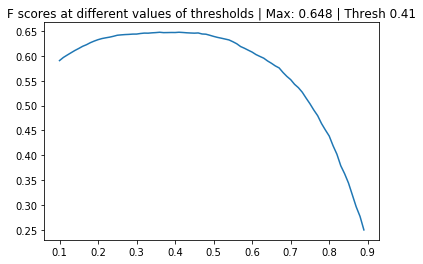

In [11]:
#%%time
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = SpatialDropout1D(0.2)(x)
x = Reshape((maxlen, embed_size, 1))(x)

filt_sizes = [1,2,3,5]
max_pools = []
for i in range(len(filt_sizes)):
    conv = Conv2D(128, kernel_size=(filt_sizes[i], embed_size),
                  kernel_initializer="he_normal", activation="elu")(x)
    max_pools.append(MaxPool2D(pool_size=(maxlen-filt_sizes[i]+1, 1))(conv))
    
x = Concatenate(axis=1)(max_pools)
x = Flatten()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())
#"""
## Train the model 
model.fit(train_X, train_y, batch_size=512, epochs=3, validation_data=(val_X, val_y))

#plot the best threshold and metric
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
f1_scores = []
threshs = np.arange(0.1, 0.9, 0.01)
for thresh in threshs:
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))
    f1_scores.append(f1_score)
    
plt.plot(threshs, f1_scores)
max_fscore = np.round(f1_scores[np.argmax(f1_scores)], 3)
max_thresh = np.round(threshs[np.argmax(f1_scores)], 3)
plt.title("F scores at different values of thresholds | Max: {} | Thresh {}".format(max_fscore, max_thresh))

#"""